In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

transform = transforms.Compose([
        transforms.Resize(224, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size = 40

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset=torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

dataloaders = {'train' : trainloader, 'val' : testloader }
dataset_sizes = { 'train' : len(trainset) , 'val' : len(testset) }

class_names = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #GPU 사용가능 여부확인

100%|██████████| 170498071/170498071 [00:05<00:00, 28823446.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  cat  ship   cat  bird


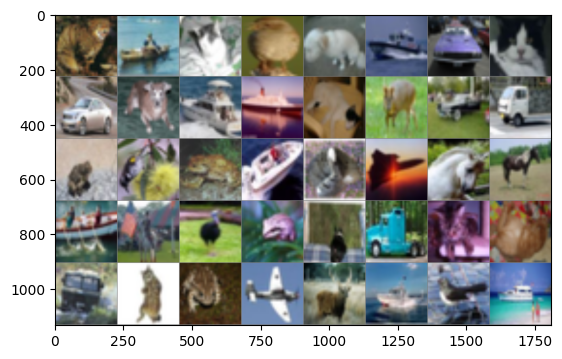

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = next(iter(trainloader))


#print(tf.size(images))
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))
plt.show()

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10).cuda()

model_ft = model_ft.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]


In [8]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #epoch를 카운트
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train mode와 validation mode 순으로 진행
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # dataloader로부터 dataset과 그에 해당되는 label을 불러온다.
            for inputs, labels in dataloaders[phase]:  
                inputs = inputs.to(device) #GPU로 입력데이터를 올림
                labels = labels.to(device) #GPU로 label을 올림
                # zero the parameter gradients
                optimizer.zero_grad()  #Gradient를 0으로 초기화

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).cuda()
                    _, preds = torch.max(outputs, 1) # 마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정
                    loss = criterion(outputs, labels).cuda()

                    # backward + optimize only if in training phase
                    if phase == 'train': # training 모드에서는 weight를 update한다.
                        loss.backward()
                        optimizer.step()
                    else:
                        preds=preds.cpu()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                preds = preds.cuda()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


print('================Finished modeling')

================Finished modeling


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.4326 Acc: 0.8589
val Loss: 0.2042 Acc: 0.9309

Epoch 1/19
----------
train Loss: 0.1585 Acc: 0.9466
val Loss: 0.1646 Acc: 0.9427

Epoch 2/19
----------
train Loss: 0.0862 Acc: 0.9729
val Loss: 0.1562 Acc: 0.9458

Epoch 3/19
----------
train Loss: 0.0493 Acc: 0.9863
val Loss: 0.1576 Acc: 0.9493

Epoch 4/19
----------
train Loss: 0.0274 Acc: 0.9936
val Loss: 0.1628 Acc: 0.9494

Epoch 5/19
----------
train Loss: 0.0175 Acc: 0.9963
val Loss: 0.1631 Acc: 0.9508

Epoch 6/19
----------
train Loss: 0.0110 Acc: 0.9984
val Loss: 0.1588 Acc: 0.9535

Epoch 7/19
----------
train Loss: 0.0095 Acc: 0.9988
val Loss: 0.1599 Acc: 0.9532

Epoch 8/19
----------
train Loss: 0.0087 Acc: 0.9989
val Loss: 0.1572 Acc: 0.9521

Epoch 9/19
----------
train Loss: 0.0079 Acc: 0.9991
val Loss: 0.1594 Acc: 0.9525

Epoch 10/19
----------
train Loss: 0.0077 Acc: 0.9993
val Loss: 0.1591 Acc: 0.9526

Epoch 11/19
----------
train Loss: 0.0075 Acc: 0.9993
val Loss: 0.1593 Acc: 0.9521

Epoch 12/19
----------
t

In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

GroundTruth:  cat   ship  ship  plane


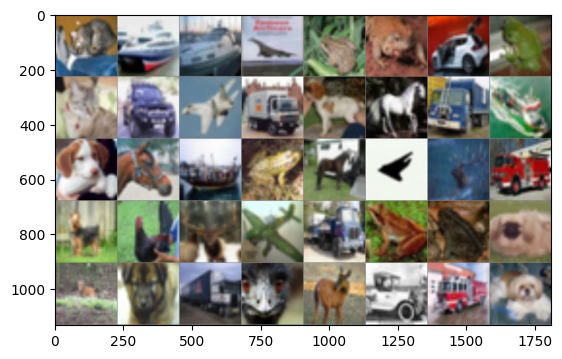

In [19]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(4)))

In [14]:
type(train_model)

function

In [17]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  